In [88]:
# import libraries

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, cohen_kappa_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

RSEED=42

In [89]:
# read data
df=pd.read_csv('/Users/annelahann/neue-fische/RiffRefine/data/data_with_target.csv')
df.head()


,Unnamed: 0,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,...,soundcloud_website,track_title_char_count,album_information_bin,artist_bio_bin,months_life,listens_month,bonus_listens,listens_incl_bonus,listens_bins,genre_pred
0,0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,False,4,1,1,101,12.801980,0.0,1293.0,2,2
1,1,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,False,10,1,1,101,11.396040,0.0,1151.0,1,2
2,2,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,...,False,7,0,1,101,496.386139,0.0,50135.0,4,1
3,3,140,1,2008-11-26 01:49:59,1,61,1300,The Blind Spot,1,Album,...,False,18,1,1,101,12.861386,0.0,1299.0,2,1
4,4,141,0,2008-11-26 01:49:57,1,60,1304,Every Man For Himself,2,Album,...,False,4,1,1,101,7.178218,0.0,725.0,1,1


In [91]:
df['listens_bins']=df['listens_bins']-1
df['listens_bins'].value_counts()

listens_bins
1    2054
2    2053
3    1960
0    1933
Name: count, dtype: int64

In [92]:
# Define predictors and target variable
mfcc = [col for col in df.columns if col.startswith('mfcc')]
chroma = [col for col in df.columns if col.startswith('chroma')]
#chroma1 = [col for col in df.columns if col.startswith('chroma_stft_mean')]
#chroma2 = [col for col in df.columns if col.startswith('chroma_cqt_mean')]
#chroma3 = [col for col in df.columns if col.startswith('chroma_cens_mean')]
rmse = [col for col in df.columns if col.startswith('rmse')]
zcr = [col for col in df.columns if col.startswith('zcr')]
spectral = [col for col in df.columns if col.startswith('spectral')]
#spectral1 = [col for col in df.columns if col.startswith('spectral_rolloff_mean')]
#spectral2 = [col for col in df.columns if col.startswith('spectral_bandwith_mean')]
#spectral3 = [col for col in df.columns if col.startswith('spectral_centroid_mean')]
#spectral4 = [col for col in df.columns if col.startswith('spectral_contrast_mean')]
tonnetz = [col for col in df.columns if col.startswith('tonnetz')]

X = df[['track_genre_top','track_bit_rate','track_duration','album_information_bin','album_tracks','other_website','soundcloud_website','artist_bio_bin','track_title_char_count']+mfcc+chroma+rmse+zcr+spectral+tonnetz]
#X = df[['track_genre_top','track_bit_rate','track_duration','album_information_bin','artist_website_bin','month']+mfcc+chroma1+chroma2+chroma3+rmse+zcr+spectral1+spectral2+spectral3+spectral4+tonnetz]
#X = df[['track_genre_top','track_bit_rate','track_duration','album_information_bin','album_tracks','other_website','soundcloud_website','artist_bio_bin','track_title_char_count']]
y = df['listens_bins']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")


We have 8000 observations in our dataset and 527 features
Our target vector has also 8000 values


In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 527 entries, track_genre_top to tonnetz_std_06
dtypes: bool(2), float64(518), int64(6), object(1)
memory usage: 32.1+ MB


In [94]:
#OnehotEncoding genre

X = pd.get_dummies(X, columns=['track_genre_top'], drop_first=True)


In [95]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
X_test

X_train shape: (6400, 533)
X_test shape: (1600, 533)
y_train shape: (6400,)
y_test shape: (1600,)


,track_bit_rate,track_duration,album_information_bin,album_tracks,other_website,soundcloud_website,artist_bio_bin,track_title_char_count,mfcc_kurtosis_01,mfcc_kurtosis_02,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Hip-Hop,track_genre_top_Instrumental,track_genre_top_International,track_genre_top_Pop,track_genre_top_Rock
2215,320000,209,1,12,True,False,0,9,1.934985,5.384943,...,0.052970,0.013487,0.022031,False,False,False,False,False,True,False
2582,256000,275,1,31,False,False,1,11,1.847230,1.265649,...,0.093105,0.022865,0.028800,False,False,False,False,False,False,True
1662,256000,255,1,32,True,False,1,11,1.385971,3.276368,...,0.081955,0.017371,0.016673,False,False,False,False,True,False,False
3027,320000,265,1,9,True,False,1,14,-0.128319,-0.474533,...,0.098877,0.019089,0.016183,False,False,False,False,False,False,False
4343,228446,494,1,19,False,True,1,27,-0.296733,-0.215461,...,0.102545,0.023823,0.025166,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,320000,320,1,11,True,False,0,16,0.674864,0.610132,...,0.156483,0.026595,0.019843,False,False,False,False,False,False,False
7979,320000,201,1,8,True,False,1,19,-1.175209,4.304868,...,0.114933,0.022845,0.025820,False,False,False,True,False,False,False
1115,320000,297,1,3,True,False,1,7,4.776399,16.716047,...,0.054953,0.016697,0.017810,True,False,False,False,False,False,False
6093,320000,251,1,8,True,False,1,44,0.469547,-0.579296,...,0.070686,0.015493,0.020513,False,False,True,False,False,False,False


In [96]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled


array([[ 0.80081919, -0.39231651,  0.48309243, ...,  2.67060806,
        -0.3790436 , -0.37525986],
       [-1.25900183,  0.06557926, -2.06999723, ..., -0.37444656,
        -0.3790436 , -0.37525986],
       [-0.15134508, -1.07407243,  0.48309243, ..., -0.37444656,
        -0.3790436 , -0.37525986],
       ...,
       [ 0.89673488, -0.24986005,  0.48309243, ..., -0.37444656,
         2.63821891, -0.37525986],
       [ 0.89673488,  1.81575863,  0.48309243, ..., -0.37444656,
        -0.3790436 , -0.37525986],
       [-0.12597827, -0.86038773,  0.48309243, ..., -0.37444656,
        -0.3790436 , -0.37525986]])

In [73]:

rf = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               n_jobs=-1, verbose = 1)

rf.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [74]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 2496
Average maximum depth 26


In [75]:
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

y_train_probs_rf = rf.predict_proba(X_train_scaled)[:, 1]
y_test_probs_rf = rf.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [76]:
# Performance DT Train Data

conf_matrix= confusion_matrix(y_train, y_train_pred_rf)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_rf).round(3))

100.0
0.0
0.0
0.0
--------------------------------
1.0


In [77]:
# Performance DT Test Data

conf_matrix= confusion_matrix(y_test, y_test_pred_rf)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_rf).round(3))

48.9
35.8
11.0
4.3
--------------------------------
0.32


In [78]:
kappa_scorer = make_scorer(cohen_kappa_score)

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(2, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 100).astype(int)),
    'min_samples_split': [1,2,3,10],
    'bootstrap': [True, False]
}


# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
grid_rf = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring =kappa_scorer, cv = 5, 
                        n_iter = 10, verbose = 5, random_state=RSEED)


grid_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END bootstrap=False, max_depth=16, max_features=0.6, max_leaf_nodes=41, min_samples_split=1, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=17, max_features=0.8999999999999999, max_leaf_nodes=48, min_samples_split=1, n_estimators=44;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=False, max_depth=17, max_features=0.8999999999999999, max_leaf_nodes=48, min_samples_split=1, n_estimators=44;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=16, max_features=0.6, max_leaf_nodes=41, min_samples_split=1, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=False, max_depth=16, max_features=0.6, max_leaf_nodes=41, min_samples_split=1, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=False, max_depth=16, max_features=0.6, max_leaf_nodes=41, min_samples_split=1, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END bo

/Users/annelahann/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelahann/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annelahann/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/annelahann/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/skl

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 2, 2, 2, 3, 3, 3, 4,
                                                      4, 4, 5, 5, 6, 6, 6, 7, 7,
                                                      7, 8, 8, 8, 9, 9, 10, 10,
                                                      10, 11, 11, 11, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 11,
                                                           11, 12, 12, 12, 13,
                                                           13, 14, 14, 14, 15,
                                                           15, 16, 16, 16, 17,
                                                           17, 18, 18, 18, 19,
                                                           19, 20, 20, 20, 21, ...],
                                        'min_samples_split': [1, 2, 3, 10],
                                        'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94,  96,  98, 100])},
                   random_state=42, scoring=make_scorer(cohen_kappa_score),
                   verbose=5)

In [80]:
# Show best parameters
grid_rf.best_params_

{'n_estimators': 79,
 'min_samples_split': 10,
 'max_leaf_nodes': 49,
 'max_features': 0.7,
 'max_depth': 15,
 'bootstrap': True}

In [81]:
# Save best model (including fitted preprocessing steps) as best_model 

best_model = grid_rf.best_estimator_
best_model.feature_importances_


array([4.69700340e-03, 1.24530833e-03, 0.00000000e+00, 1.59780764e-02,
       9.74691041e-05, 2.35672863e-04, 1.59011186e-04, 7.58624192e-04,
       1.02931582e-03, 1.04807642e-03, 2.77552399e-03, 2.09510989e-03,
       9.51826357e-04, 7.28320389e-04, 1.45505899e-03, 1.14758854e-03,
       6.84865364e-04, 9.78041147e-04, 3.05078752e-04, 7.01872496e-04,
       5.62464087e-04, 3.16911509e-04, 1.15132850e-04, 7.08243090e-04,
       4.43955563e-04, 2.44350087e-04, 1.00762653e-03, 5.00198570e-04,
       1.48206060e-02, 1.61152803e-03, 8.79112601e-04, 1.34597059e-03,
       5.05604137e-03, 1.02923086e-03, 2.20003202e-03, 1.47682011e-03,
       1.16040190e-03, 1.66578345e-03, 1.03489908e-03, 6.58551856e-04,
       4.36955516e-04, 1.46133012e-03, 1.80530939e-03, 4.02988349e-04,
       3.59912398e-04, 3.39505040e-04, 0.00000000e+00, 2.42356667e-04,
       1.48363788e-03, 5.34816867e-04, 4.05735785e-03, 1.70862254e-03,
       1.18558142e-03, 6.67292869e-04, 3.04183792e-03, 1.05709776e-04,
      

In [82]:
y_train_pred_rf = best_model.predict(X_train_scaled)
y_test_pred_rf = best_model.predict(X_test_scaled)

y_train_probs_rf = best_model.predict_proba(X_train_scaled)[:, 1]
y_test_probs_rf = best_model.predict_proba(X_test_scaled)[:, 1]


In [83]:

conf_matrix= confusion_matrix(y_test, y_test_pred_rf)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_rf).round(3))

53.6
33.4
9.7
3.2
--------------------------------
0.386


In [84]:
conf_matrix= confusion_matrix(y_train, y_train_pred_rf)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_rf).round(3))

61.0
26.5
9.4
3.0
--------------------------------
0.482


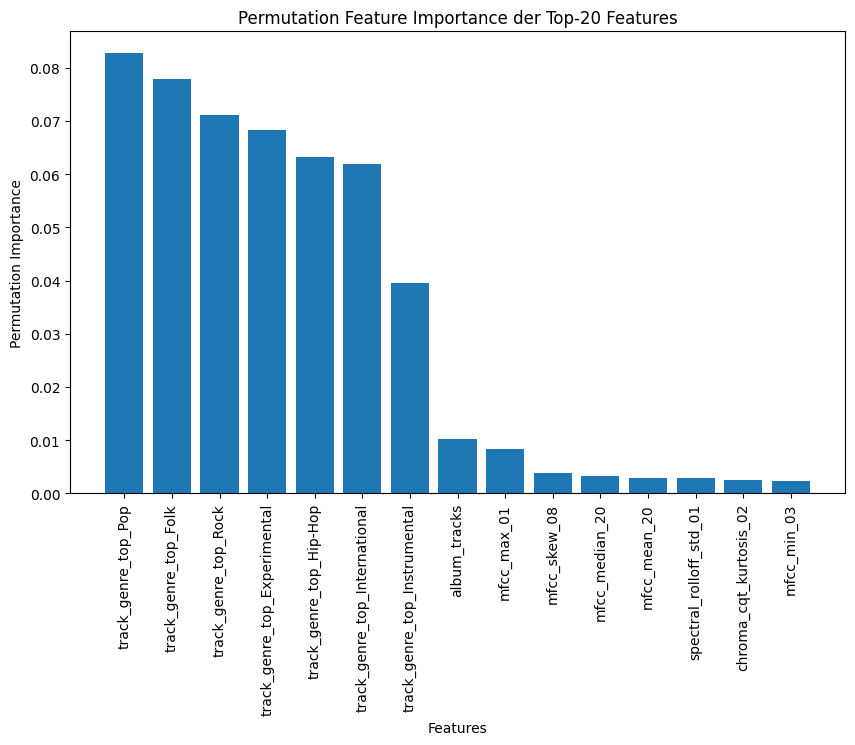

In [85]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_train_scaled, y_train,random_state=RSEED)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
feature_names = X.columns.tolist() 
top_features = 15  
plt.figure(figsize=(10, 6))
plt.bar(range(top_features), perm_importance.importances_mean[sorted_idx][:top_features], align="center")
plt.xticks(range(top_features), [feature_names[i] for i in sorted_idx[:top_features]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Permutation Feature Importance der Top-20 Features')
plt.show()

In [97]:
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier(random_state=RSEED, tree_method="hist",max_depth=5,gamma=1.0,learning_rate=0.1,reg_lambda=2,scale_pos_weight=1,n_estimators=75)
xgb.fit(X_train_scaled, y_train)

/Users/annelahann/neue-fische/RiffRefine/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:09:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [98]:
y_train_pred_xgb = xgb.predict(X_train_scaled)
y_test_pred_xgb = xgb.predict(X_test_scaled)

In [99]:
conf_matrix= confusion_matrix(y_train, y_train_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_xgb).round(3))

83.2
11.5
4.3
1.0
--------------------------------
0.776


In [100]:
conf_matrix= confusion_matrix(y_test, y_test_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_xgb).round(3))

54.4
33.4
9.4
2.9
--------------------------------
0.395


In [106]:
grid_params = {
    'n_estimators': [70,100],
    'gamma': [0.5,1.0],
   # 'reg_lambda': [1.0,2.0,5.0],
    'max_depth': [3,5,8],
    'learning_rate': [0.01,0.1,0.5]
}

gs = GridSearchCV(
    XGBClassifier(random_state=RSEED, tree_method="hist"),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1,
    scoring=kappa_scorer)

In [107]:
xgb_gs = gs.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [108]:
xgb_gs.best_params_

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}

In [109]:
best_model = xgb_gs.best_estimator_

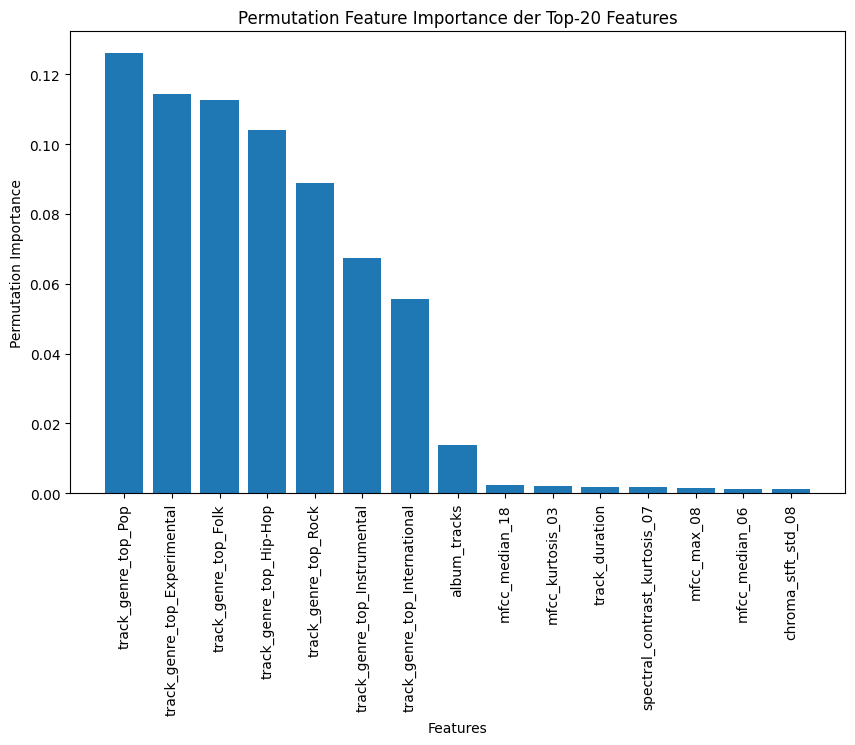

In [115]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_train_scaled, y_train,random_state=RSEED)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
feature_names = X.columns.tolist() 
top_features = 15  
plt.figure(figsize=(10, 6))
plt.bar(range(top_features), perm_importance.importances_mean[sorted_idx][:top_features], align="center")
plt.xticks(range(top_features), [feature_names[i] for i in sorted_idx[:top_features]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Permutation Feature Importance der Top-20 Features')
plt.show()

In [111]:
y_train_pred_xgb = best_model.predict(X_train_scaled)
y_test_pred_xgb = best_model.predict(X_test_scaled)

In [112]:
conf_matrix= confusion_matrix(y_train, y_train_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_xgb).round(3))

99.7
0.3
0.0
0.0
0.0
--------------------------------
0.996


In [113]:
conf_matrix= confusion_matrix(y_test, y_test_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_xgb).round(3))

54.8
34.8
8.0
2.4
0.0
--------------------------------
0.4
